In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
from pprint import pprint
import sys
import itertools
sys.path.append("/Users/minjunpark/Documents/RLfinance")
sys.path.append("/Users/minjunpark/Documents/RLfinance/src")

In [2]:
from src import utils
from data_loader import data_loader

In [3]:
# Create relevant directory
utils.create_dir()

In [4]:
tickers = ['FB', 'AMZN', 'AAPL', 'NVDA', 'GOOG']
indicators = ['RSI', 'SMA']
start_date = '2015-01-01'
end_date = '2016-01-01'

In [5]:
df = data_loader.yahooProcessor(tickers, indicators, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1145, 10)


In [6]:
df

,date,open,high,low,close,volume,tic,RSI_14,SMA_25,day
0,2015-02-05,30.004999,30.057501,29.812500,27.219952,168984800,AAPL,64.058615,25.322263,3
1,2015-02-05,366.000000,378.799988,365.899994,373.890015,7247600,AMZN,76.932891,313.278401,3
2,2015-02-05,75.709999,75.980003,75.209999,75.610001,15062600,FB,43.454478,76.563200,3
3,2015-02-05,522.355896,527.052979,520.660522,526.135498,1849765,GOOG,50.774157,513.901885,3
4,2015-02-05,5.045000,5.125000,5.040000,4.925518,14044800,NVDA,55.698837,4.782248,3
...,...,...,...,...,...,...,...,...,...,...
1140,2015-12-31,26.752501,26.757500,26.205000,24.199886,163649200,AAPL,34.017151,25.861001,3
1141,2015-12-31,686.080017,687.750000,675.890015,675.890015,3749600,AMZN,55.110352,669.486807,3
1142,2015-12-31,106.000000,106.169998,104.620003,104.660004,18391100,FB,48.557170,105.334000,3
1143,2015-12-31,769.500000,769.500000,758.340027,758.880005,1500900,GOOG,54.514644,754.352402,3


# Data split into train and test

In [7]:
train = utils.data_split(df, '2015-01-01','2015-06-01')
trade = utils.data_split(df, '2015-06-01','2016-01-01')
# Check the length of the two datasets
print(len(train))
print(len(trade))

395
750


# Get trading environment

In [8]:
from src.env_stocktrading import StockTradingEnv

In [9]:
ratio_list = ['RSI_14', 'SMA_25']

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 21


In [10]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [11]:
# Environment for trading
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Implement RL algorithms

In [20]:
from models.models import DRLAgent

In [21]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [22]:
%%time
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 128        |
|    time_elapsed    | 2          |
|    total_timesteps | 316        |
| train/             |            |
|    actor_loss      | -1.72e+04  |
|    critic_loss     | 4.72e+06   |
|    learning_rate   | 0.001      |
|    n_updates       | 158        |
|    reward          | 0.55751085 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 90         |
|    time_elapsed    | 6          |
|    total_timesteps | 632        |
| train/             |            |
|    actor_loss      | -1.03e+04  |
|    critic_loss     | 1.71e+06   |
|    learning_rate   | 0.001      |
|    n_updates       | 474        |
|    reward          | 0.55751085 |
-----------------------------------
day: 78, episode: 10
begin_total_asset: 1000000.00
end_total_ass

-----------------------------------
| time/              |            |
|    episodes        | 68         |
|    fps             | 72         |
|    time_elapsed    | 74         |
|    total_timesteps | 5372       |
| train/             |            |
|    actor_loss      | 236        |
|    critic_loss     | 2.42e+04   |
|    learning_rate   | 0.001      |
|    n_updates       | 5214       |
|    reward          | 0.55751085 |
-----------------------------------
day: 78, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 1117933.54
total_reward: 117933.54
total_cost: 999.00
total_trades: 234
Sharpe: 1.401
-----------------------------------
| time/              |            |
|    episodes        | 72         |
|    fps             | 71         |
|    time_elapsed    | 79         |
|    total_timesteps | 5688       |
| train/             |            |
|    actor_loss      | 253        |
|    critic_loss     | 8.58e+03   |
|    learning_rate   | 0.001      |
|    n_updates    

day: 78, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 1117933.54
total_reward: 117933.54
total_cost: 999.00
total_trades: 234
Sharpe: 1.401
-----------------------------------
| time/              |            |
|    episodes        | 132        |
|    fps             | 71         |
|    time_elapsed    | 146        |
|    total_timesteps | 10428      |
| train/             |            |
|    actor_loss      | 41.6       |
|    critic_loss     | 5.45e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 10270      |
|    reward          | 0.55751085 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 136        |
|    fps             | 70         |
|    time_elapsed    | 151        |
|    total_timesteps | 10744      |
| train/             |            |
|    actor_loss      | 45.3       |
|    critic_loss     | 151        |
|    learning_rate   | 0.001      |
|    n_updates   

-----------------------------------
| time/              |            |
|    episodes        | 192        |
|    fps             | 70         |
|    time_elapsed    | 216        |
|    total_timesteps | 15168      |
| train/             |            |
|    actor_loss      | 13.6       |
|    critic_loss     | 20.7       |
|    learning_rate   | 0.001      |
|    n_updates       | 15010      |
|    reward          | 0.55751085 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 196        |
|    fps             | 70         |
|    time_elapsed    | 220        |
|    total_timesteps | 15484      |
| train/             |            |
|    actor_loss      | 12.8       |
|    critic_loss     | 60.8       |
|    learning_rate   | 0.001      |
|    n_updates       | 15326      |
|    reward          | 0.55751085 |
-----------------------------------
day: 78, episode: 200
begin_total_asset: 1000000.00
end_total_as

-----------------------------------
| time/              |            |
|    episodes        | 256        |
|    fps             | 69         |
|    time_elapsed    | 292        |
|    total_timesteps | 20224      |
| train/             |            |
|    actor_loss      | 3.95       |
|    critic_loss     | 4.48       |
|    learning_rate   | 0.001      |
|    n_updates       | 20066      |
|    reward          | 0.55751085 |
-----------------------------------
day: 78, episode: 260
begin_total_asset: 1000000.00
end_total_asset: 1117933.54
total_reward: 117933.54
total_cost: 999.00
total_trades: 234
Sharpe: 1.401
-----------------------------------
| time/              |            |
|    episodes        | 260        |
|    fps             | 69         |
|    time_elapsed    | 297        |
|    total_timesteps | 20540      |
| train/             |            |
|    actor_loss      | 3.31       |
|    critic_loss     | 3.44       |
|    learning_rate   | 0.001      |
|    n_updates   

day: 78, episode: 320
begin_total_asset: 1000000.00
end_total_asset: 1117933.54
total_reward: 117933.54
total_cost: 999.00
total_trades: 234
Sharpe: 1.401
-----------------------------------
| time/              |            |
|    episodes        | 320        |
|    fps             | 68         |
|    time_elapsed    | 368        |
|    total_timesteps | 25280      |
| train/             |            |
|    actor_loss      | -0.287     |
|    critic_loss     | 2.25       |
|    learning_rate   | 0.001      |
|    n_updates       | 25122      |
|    reward          | 0.55751085 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 324        |
|    fps             | 68         |
|    time_elapsed    | 372        |
|    total_timesteps | 25596      |
| train/             |            |
|    actor_loss      | -0.673     |
|    critic_loss     | 2.63       |
|    learning_rate   | 0.001      |
|    n_updates   

-----------------------------------
| time/              |            |
|    episodes        | 380        |
|    fps             | 68         |
|    time_elapsed    | 439        |
|    total_timesteps | 30020      |
| train/             |            |
|    actor_loss      | -5.34      |
|    critic_loss     | 1.84       |
|    learning_rate   | 0.001      |
|    n_updates       | 29862      |
|    reward          | 0.55751085 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 384        |
|    fps             | 68         |
|    time_elapsed    | 443        |
|    total_timesteps | 30336      |
| train/             |            |
|    actor_loss      | -3.4       |
|    critic_loss     | 7.76e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 30178      |
|    reward          | 0.55751085 |
-----------------------------------
-----------------------------------
| time/              |      

-----------------------------------
| time/              |            |
|    episodes        | 444        |
|    fps             | 68         |
|    time_elapsed    | 514        |
|    total_timesteps | 35076      |
| train/             |            |
|    actor_loss      | -0.297     |
|    critic_loss     | 3.36       |
|    learning_rate   | 0.001      |
|    n_updates       | 34918      |
|    reward          | 0.55751085 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 448        |
|    fps             | 68         |
|    time_elapsed    | 518        |
|    total_timesteps | 35392      |
| train/             |            |
|    actor_loss      | -0.33      |
|    critic_loss     | 3.39       |
|    learning_rate   | 0.001      |
|    n_updates       | 35234      |
|    reward          | 0.55751085 |
-----------------------------------
day: 78, episode: 450
begin_total_asset: 1000000.00
end_total_as

-----------------------------------
| time/              |            |
|    episodes        | 508        |
|    fps             | 68         |
|    time_elapsed    | 588        |
|    total_timesteps | 40132      |
| train/             |            |
|    actor_loss      | -1.48      |
|    critic_loss     | 3.46       |
|    learning_rate   | 0.001      |
|    n_updates       | 39974      |
|    reward          | 0.55751085 |
-----------------------------------
day: 78, episode: 510
begin_total_asset: 1000000.00
end_total_asset: 1117933.54
total_reward: 117933.54
total_cost: 999.00
total_trades: 234
Sharpe: 1.401
-----------------------------------
| time/              |            |
|    episodes        | 512        |
|    fps             | 68         |
|    time_elapsed    | 592        |
|    total_timesteps | 40448      |
| train/             |            |
|    actor_loss      | -1.58      |
|    critic_loss     | 3.19       |
|    learning_rate   | 0.001      |
|    n_updates   

day: 78, episode: 570
begin_total_asset: 1000000.00
end_total_asset: 1117933.54
total_reward: 117933.54
total_cost: 999.00
total_trades: 234
Sharpe: 1.401
-----------------------------------
| time/              |            |
|    episodes        | 572        |
|    fps             | 68         |
|    time_elapsed    | 662        |
|    total_timesteps | 45188      |
| train/             |            |
|    actor_loss      | -2.92      |
|    critic_loss     | 3.43       |
|    learning_rate   | 0.001      |
|    n_updates       | 45030      |
|    reward          | 0.55751085 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 576        |
|    fps             | 68         |
|    time_elapsed    | 667        |
|    total_timesteps | 45504      |
| train/             |            |
|    actor_loss      | -3         |
|    critic_loss     | 3.69       |
|    learning_rate   | 0.001      |
|    n_updates   

-----------------------------------
| time/              |            |
|    episodes        | 632        |
|    fps             | 68         |
|    time_elapsed    | 732        |
|    total_timesteps | 49928      |
| train/             |            |
|    actor_loss      | -3.94      |
|    critic_loss     | 3.6        |
|    learning_rate   | 0.001      |
|    n_updates       | 49770      |
|    reward          | 0.55751085 |
-----------------------------------


# Trading

In [23]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [24]:
trade.head()

,date,open,high,low,close,volume,tic,RSI_14,SMA_25,day
0,2015-06-01,32.570000,32.847500,32.512501,29.749317,128451200,AAPL,54.749551,29.339157,0
0,2015-06-01,430.399994,433.160004,426.200012,430.920013,2253300,AMZN,58.766483,427.539601,0
0,2015-06-01,79.300003,80.379997,78.660004,80.290001,18119000,FB,50.697668,79.620800,0
0,2015-06-01,536.789978,536.789978,529.760010,533.989990,1904300,GOOG,47.290535,537.369600,0
0,2015-06-01,5.567500,5.650000,5.532500,5.425305,37266000,NVDA,61.413760,5.230336,0


In [25]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [26]:
df_account_value.shape

(150, 2)

In [27]:
df_account_value.tail()

,date,account_value
145,2015-12-24,1.489238e+06
146,2015-12-28,1.515206e+06
147,2015-12-29,1.556613e+06
148,2015-12-30,1.545278e+06
149,2015-12-31,1.515831e+06


In [28]:
df_actions.head()

,AAPL,AMZN,FB,GOOG,NVDA
date,,,,,
2015-06-01,100,100,0,0,100
2015-06-02,100,100,0,0,100
2015-06-03,100,100,0,0,100
2015-06-04,100,100,0,0,100
2015-06-05,100,100,0,0,100


In [35]:
df_actions.to_csv('actions.csv')

# Backtesting

In [31]:
from config import config
from backtesting.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          1.011375
Cumulative returns     0.515831
Annual volatility      0.296487
Sharpe ratio           2.521630
Calmar ratio           7.436869
Stability              0.900507
Max drawdown          -0.135995
Omega ratio            1.595539
Sortino ratio          4.448947
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.580447
Daily value at risk   -0.034387
dtype: float64


In [32]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = '2015-06-01',
        end = '2016-01-01')

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (150, 8)
Annual return         -0.056636
Cumulative returns    -0.034109
Annual volatility      0.169080
Sharpe ratio          -0.263044
Calmar ratio          -0.414756
Stability              0.020931
Max drawdown          -0.136553
Omega ratio            0.956059
Sortino ratio         -0.364278
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.825591
Daily value at risk   -0.021479
dtype: float64


# Backtest plot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (150, 8)


Start date,2015-06-01
End date,2015-12-31
Total months,7
,Backtest
Annual return,101.138%
Cumulative returns,51.583%
Annual volatility,29.649%
Sharpe ratio,2.52
Calmar ratio,7.44
Stability,0.90
Max drawdown,-13.599%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.60,2015-07-30,2015-08-24,2015-09-17,36
1,9.25,2015-09-21,2015-09-29,2015-10-12,16
2,5.59,2015-12-01,2015-12-11,2015-12-29,21
3,4.52,2015-11-11,2015-11-13,2015-11-23,9
4,3.32,2015-06-23,2015-07-08,2015-07-13,15


Stress Events,mean,min,max
Fall2015,-0.08%,-6.09%,7.30%
New Normal,0.30%,-6.09%,9.13%


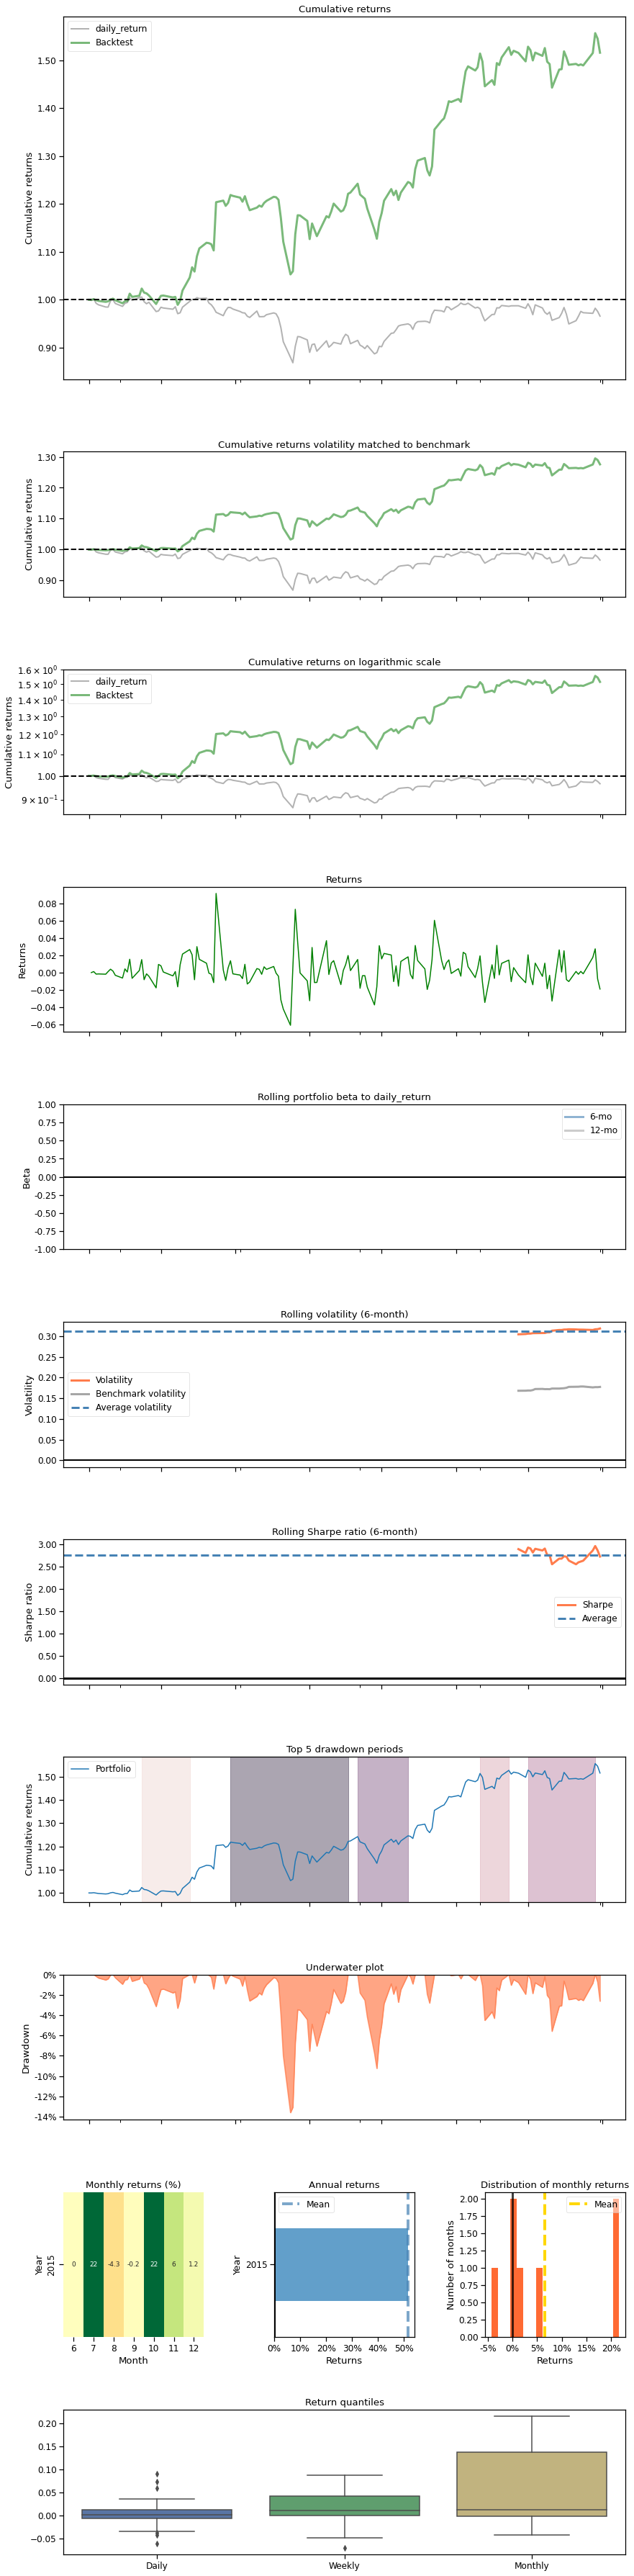

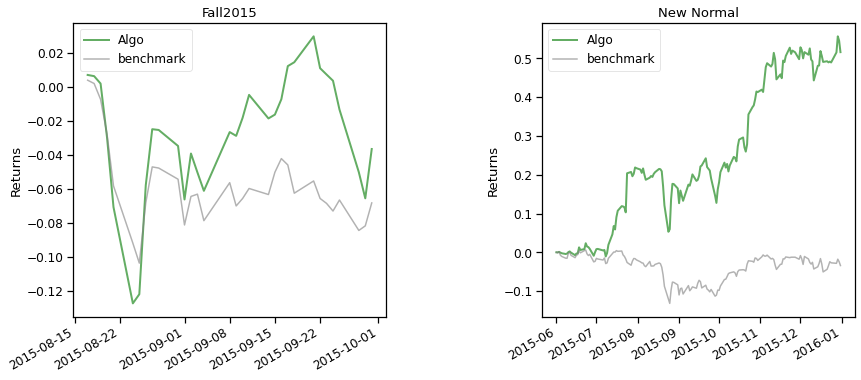

In [33]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2015-06-01',
             baseline_end = '2016-01-01')

# Save trained model

In [36]:
df_account_value

,date,account_value
0,2015-06-01,1.000000e+06
1,2015-06-02,9.999365e+05
2,2015-06-03,1.001006e+06
3,2015-06-04,9.991918e+05
4,2015-06-05,9.975650e+05
...,...,...
145,2015-12-24,1.489238e+06
146,2015-12-28,1.515206e+06
147,2015-12-29,1.556613e+06
148,2015-12-30,1.545278e+06


In [37]:
trained_ddpg
trained_ddpg.save('trained_ddpg')

In [39]:
# https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/saving_loading_dqn.ipynb#scrollTo=K1ExgtyZrIA6
from stable_baselines3 import DDPG

In [41]:
model = DDPG.load("trained_ddpg")

In [42]:
model

In [43]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=model, 
    environment = e_trade_gym)

hit end!


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (150, 8)


Start date,2015-06-01
End date,2015-12-31
Total months,7
,Backtest
Annual return,101.138%
Cumulative returns,51.583%
Annual volatility,29.649%
Sharpe ratio,2.52
Calmar ratio,7.44
Stability,0.90
Max drawdown,-13.599%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.60,2015-07-30,2015-08-24,2015-09-17,36
1,9.25,2015-09-21,2015-09-29,2015-10-12,16
2,5.59,2015-12-01,2015-12-11,2015-12-29,21
3,4.52,2015-11-11,2015-11-13,2015-11-23,9
4,3.32,2015-06-23,2015-07-08,2015-07-13,15


Stress Events,mean,min,max
Fall2015,-0.08%,-6.09%,7.30%
New Normal,0.30%,-6.09%,9.13%


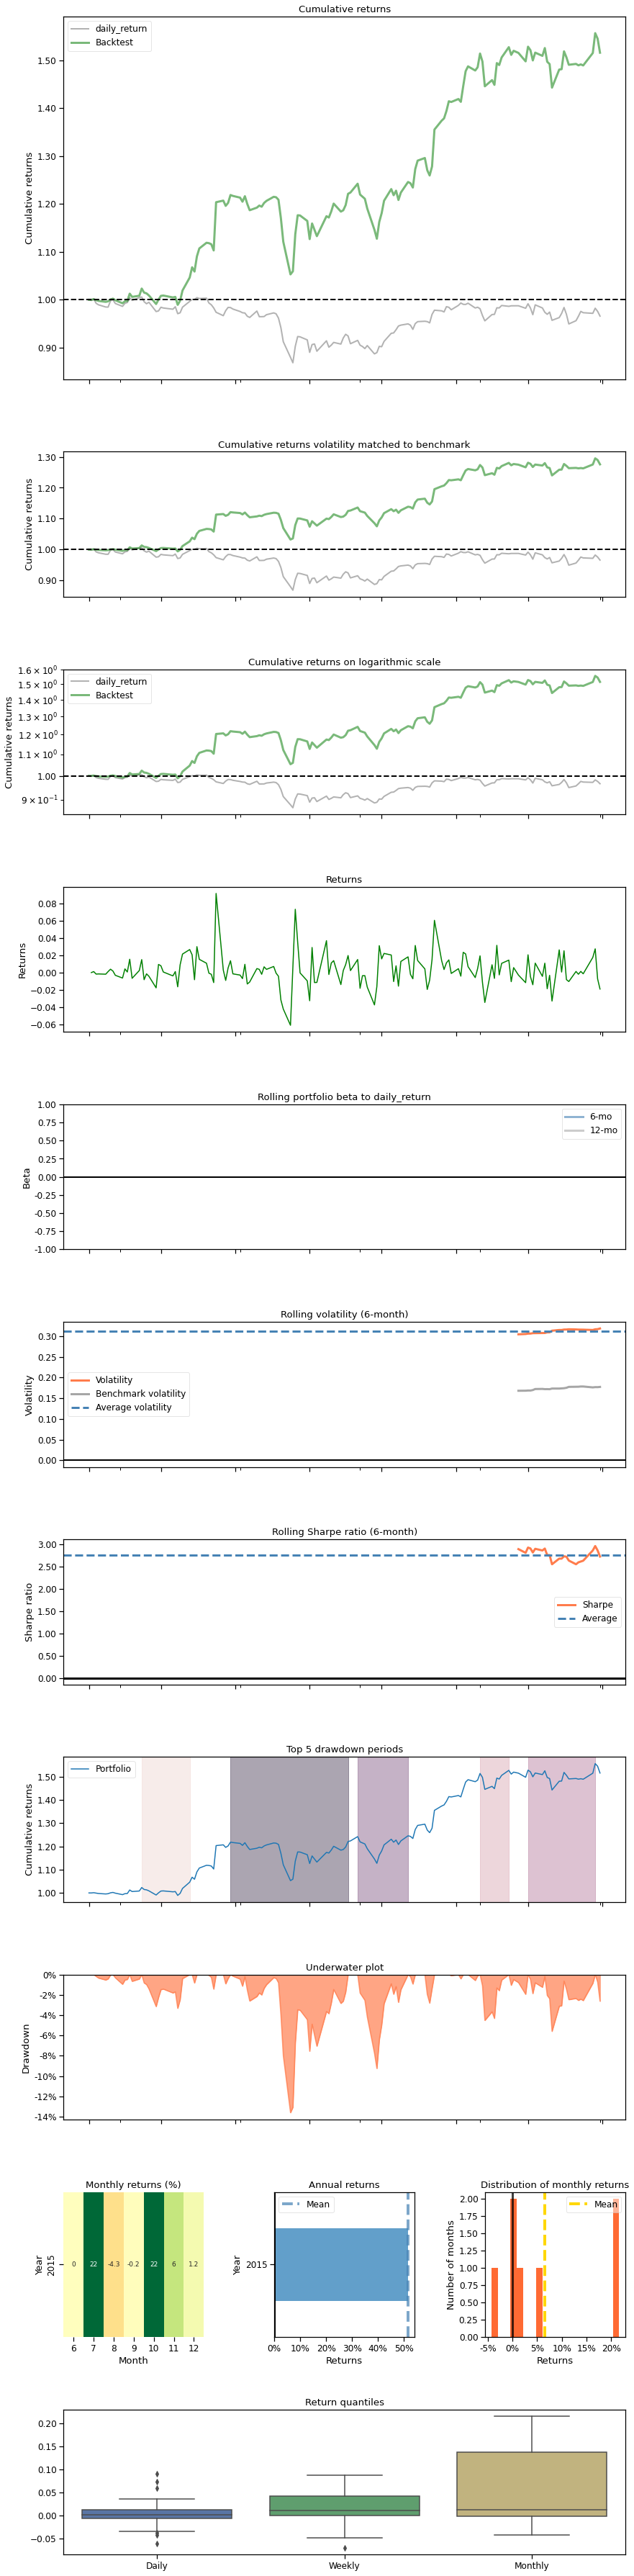

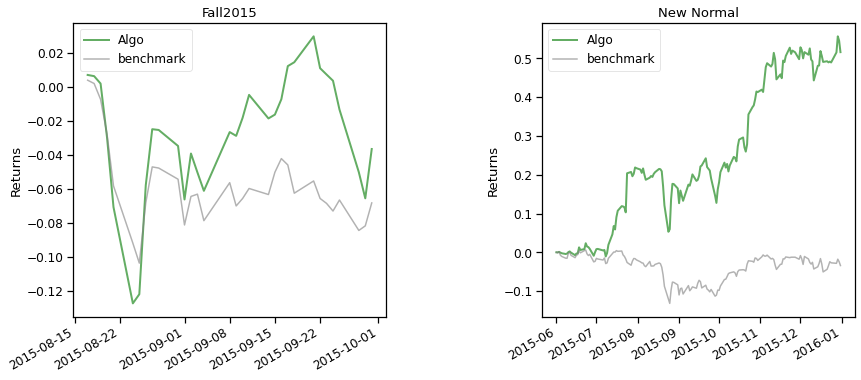

In [44]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2015-06-01',
             baseline_end = '2016-01-01')

In [3]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

In [4]:
now

'20220324-16h40'